<h1><center><font size="25">Multi-series forecasting with Python and Skforecast</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>October 2022</i></center>

+ [Skforecast: time series forecasting with Python and Scikit-learn](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)

## Multi-series forecasting


In [univariate time series forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html), a single time series is modeled as a linear or nonlinear combination of its lags. That is, the past values of the series are used to forecast its future. In multi-series forecasting, two or more time series are modeled together using a single model. Two strategies can be distinguished:

**No multivariate time series**

A single model is trained, but each time series remains independent of the others. In other words, the past values of one series are not used as predictors of other series. Why is it useful then to model everything together? Although the series do not depend on each other, they may follow the same intrinsic pattern regarding their past and future values. For example, in the same store, the sales of products A and B may not be related, but they follow the same dynamics, that of the store.

<p align="center"><img src="../images/forecaster_multi_series_train_matrix_diagram.png" style="width: 800px"></p>

In order to predict the next *n* steps, the same strategy of [recursive multi-step forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html#multi-step-forecasting) is applied. The only difference is that, the series' name for which to estimate the predictions needs to be indicated.

<p align="center"><img src="../images/forecaster_multi_series_prediction_diagram.png" style="width: 800px"></p>

**Multivariate time series**

All series are modeled considering that each time series depends not only on its past values but also on the past values of the other series. The forecaster is expected not only to learn the information of each series separately but also to relate them. For example, the measurements made by all the sensors (flow, temperature, pressure...) installed on an industrial machine such as a compressor.

<p align="center"><img src="../images/forecaster_multivariate_train_matrix_diagram.png" style="width: 800px"></p>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>
    
<code>ForecasterAutoregMultiSeries</code> class covers the use case of <b>Non Multivariate time series</b>. <a href="https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterMultiSeries.html">API Reference</a>

<code>ForecasterAutoregMultivariate</code> will be released in a future version of <a href="https://github.com/JoaquinAmatRodrigo/skforecast"><b>Skforecast</b></a> - stay tuned!

</div>

## Advantages and limitations
<br>

Multi-series forecasts do not always outperform single-series forecasts. Which one works best depends largely on the characteristics of the use case to which they are applied. However, the following heuristic is worth keeping in mind:

Advantages of multi-series:

- It is easier to maintain and monitor a single model than several.

- Since all time series are combined during training, the model has a higher learning capacity even if the series are short.

- By combining multiple time series, the model can learn more generalizable patterns.


Disadvantages of multi-series:

- If the series do not follow the same internal dynamics, the model may learn a pattern that does not represent any of them.

- The series may mask each other, so the model may not predict all of them with the same performance.

- It is more computationally demanding (time and resources) to train and backtest a big model than several small ones.

## Case of study
<br>

The objective of this study is to compare the forecasting performance achieved by a multi-series model versus using a different model for each series.

Data has been obtained from [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data). This dataset contains 913,000 sales transactions from 2013–01–01 to 2017–12–31 for 50 products (SKU) in 10 stores. The goal is to predict the next 7 days sales for 50 different items in one store using the available 5 years history.

## Libraries

In [15]:
# Libraries
# ==============================================================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

## Data

In [16]:
# Data download
# ==============================================================================================
data = pd.read_csv('./train_stores_kaggle.csv')
data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [17]:
# Data preprocessing
# ==============================================================================================
selected_store = 2
selected_items = data.item.unique() # All items
#selected_items = [1, 2, 3, 4 , 5] # Selection of items to reduce computation time

data = data[(data['store'] == selected_store) & (data['item'].isin(selected_items))].copy()
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = pd.pivot_table(
            data    = data,
            values  = 'sales',
            index   = 'date',
            columns = 'item'
        )
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]
data = data.asfreq('1D')
data = data.sort_index()
data.head(4)

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12,41,19,21,4,34,39,49,28,51,...,11,25,36,12,45,43,12,45,29,43
2013-01-02,16,33,32,14,6,40,47,42,21,56,...,19,21,35,25,50,52,13,37,25,57
2013-01-03,16,46,26,12,12,41,43,46,29,46,...,23,20,52,18,56,30,5,45,30,45
2013-01-04,20,50,34,17,16,41,44,55,32,56,...,15,28,50,24,57,46,19,32,20,45


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

Modeling 50 elements may require significant computational time. Feel free to select only a subset of items to speed up the execution.

</div>

The dataset is divided into 3 partitions: one for training, one for validation, and one for testing.

In [18]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2016-05-31 23:59:00'
end_val = '2017-05-31 23:59:00'

data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2013-01-01 00:00:00 --- 2016-05-31 00:00:00  (n=1247)
Validation dates : 2016-06-01 00:00:00 --- 2017-05-31 00:00:00  (n=365)
Test dates       : 2017-06-01 00:00:00 --- 2017-12-31 00:00:00  (n=214)


Four of the series are plotted to understand their trends and patterns. The reader is strongly encouraged to plot several more to gain an in-depth understanding of the series.

/tmp/ipykernel_7432/2707044444.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


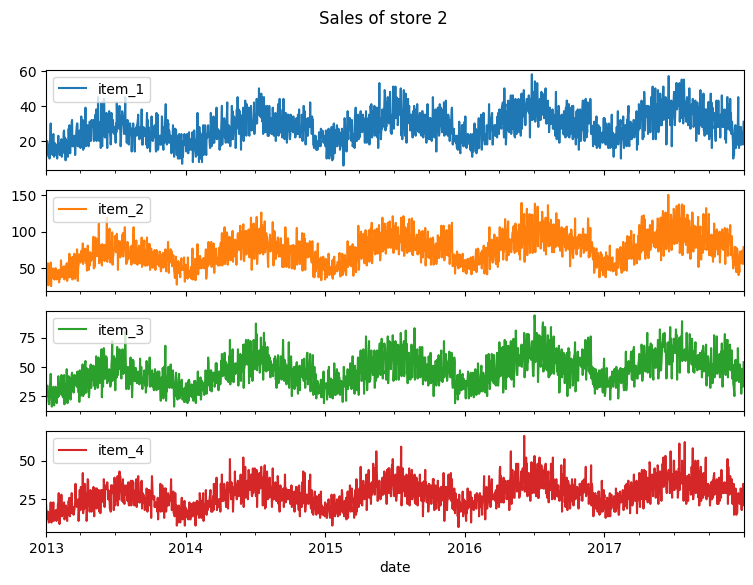

In [19]:
# Plot time series
# ======================================================================================
fig, ax = plt.subplots(figsize=(9, 6))
data.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    title    =  'Sales of store 2',
    ax = ax, 
);

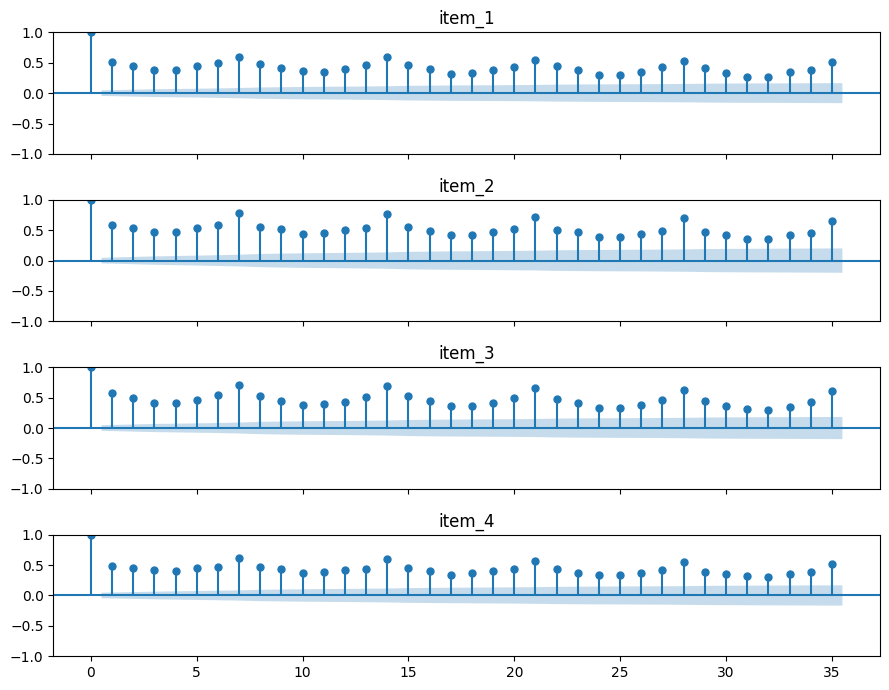

In [20]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9, 7), sharex=True)
axes = axes.flat
for i, col in enumerate(data.columns[:4]):
    plot_acf(data[col], ax=axes[i], lags=7*5)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

The autocorrelation plots show a clear association between sales on one day and sales on the same day a week earlier. This type of correlation is an indication that autoregressive models can work well.

There is also a common weekly seasonality between the series. The more similar the dynamics between the series, the more likely the model will learn useful patterns.

## Individual forecaster for each product
<br>

A different model is trained for each item of the store and its mean absolute error is estimated using [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html#backtesting).

In [21]:
# Train and backtesting a model for each item
# ======================================================================================
items = []
mae_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):

    # Define forecaster
    forecaster = ForecasterAutoreg(
                     regressor        = HistGradientBoostingRegressor(random_state=123),
                     lags             = 14,
                     transformer_y    = StandardScaler()
                 )

    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    items.append(item)
    mae_values.append(metric)
    predictions[item] = preds

# Results
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

100%|██████████| 50/50 [02:03<00:00,  2.48s/it]


## Multiseries forecaster
<br>

A single multi-series model is trained to predict the sales of each product over the next 7 days.

In [22]:
# Train and backtesting a model for all items
# ======================================================================================
items = []
mae_values = []
predictions_ms = {}

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 14,
                    transformer_series = StandardScaler(),
                )

# Backtesting forecaster for each item
for i, item in enumerate(tqdm(data.columns)):

    metric, preds = backtesting_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        level              = item,
                        series             = data,
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    items.append(item)
    mae_values.append(metric)
    predictions_ms[item] = preds

# Results
multi_series_mae = pd.Series(
                       data  = mae_values,
                       index = items,
                       name  = 'multi_series_mae'
                   )

100%|██████████| 50/50 [05:18<00:00,  6.38s/it]


## Comparison

In [23]:
# Difference of backtesting metric for each item
# ======================================================================================
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results

,uni_series_mae,multi_series_mae,improvement,improvement_(%)
item_1,6.19,5.58,0.61,9.88
item_2,9.85,9.27,0.58,5.85
item_3,8.66,7.41,1.25,14.47
item_4,5.43,4.98,0.44,8.17
item_5,5.00,4.66,0.34,6.82
item_6,10.36,10.04,0.31,3.02
item_7,10.04,9.80,0.24,2.39
item_8,11.30,10.42,0.88,7.80
item_9,9.45,8.77,0.68,7.24
item_10,11.57,10.57,1.01,8.70


In [24]:
# Average improvement for all items
# ======================================================================================
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,0.6172,6.578
min,0.0700,1.110
max,1.4900,14.470


In [25]:
# Number of series with positive and negative improvement
# ======================================================================================
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()

positive    50
dtype: int64

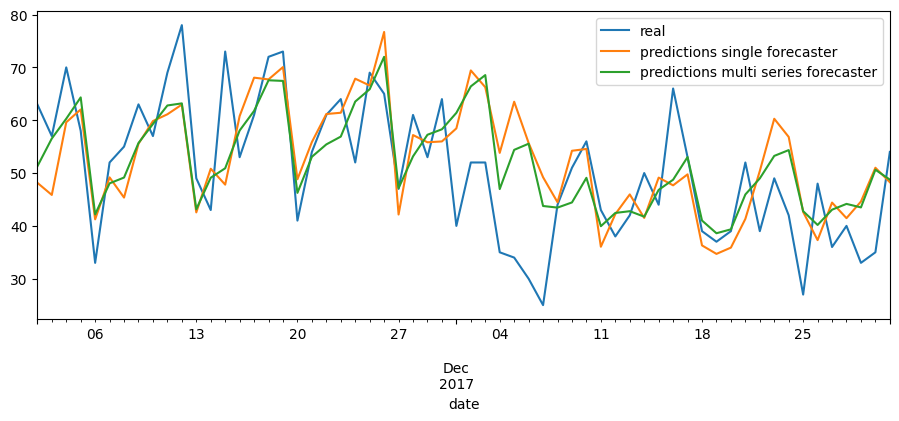

In [26]:
# Plot the item with maximum improvement
# ======================================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data_test['item_3'].tail(60).plot(ax=ax)
predictions['item_3'].tail(60).plot(ax=ax)
predictions_ms['item_3'].tail(60).plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster']);

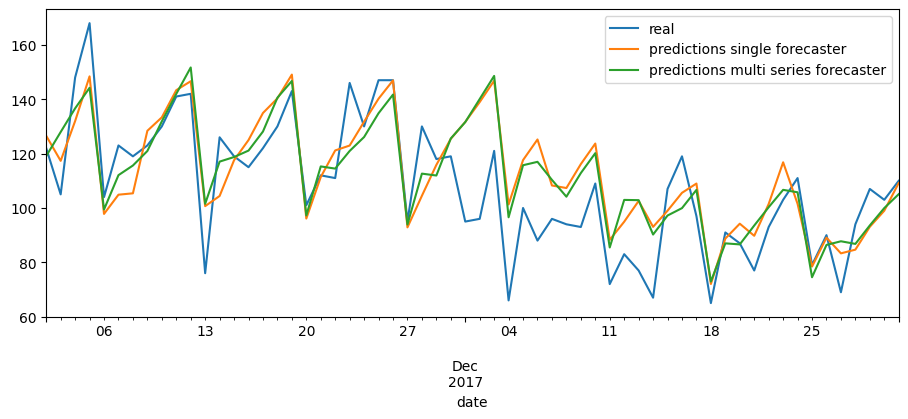

In [27]:
# Plot the item with minimum improvement
# ======================================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data_test['item_13'].tail(60).plot(ax=ax)
predictions['item_13'].tail(60).plot(ax=ax)
predictions_ms['item_13'].tail(60).plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster']);

## Impact of the series length
<br>

If a time series has few observations, the amount of information available for the model to learn is limited. This is a well know problem in real cases where there is not much historical data available. Non multivariate multi-series forecasters combine all the series during training; therefore they can access more data.

In this section, the same comparison between single-series forecasting and multi-series forecasting is performed but, this time, the length of the series is much shorter.

In [28]:
# Split data into train-validation-test
# ======================================================================================
start_train = '2017-01-01 00:00:00'
end_train = '2017-05-01 00:00:00'
end_val = '2017-07-31 23:59:00'
end_test = '2017-09-30 23:59:00'

data = data.loc[start_train:, :].copy()
data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:end_test, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2017-01-01 00:00:00 --- 2017-05-01 00:00:00  (n=121)
Validation dates : 2017-05-01 00:00:00 --- 2017-07-31 00:00:00  (n=92)
Test dates       : 2017-08-01 00:00:00 --- 2017-09-30 00:00:00  (n=61)


In [29]:
# Train and backtesting a model for each item
# ======================================================================================
items = []
mae_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):

    forecaster = ForecasterAutoreg(
                     regressor        = HistGradientBoostingRegressor(random_state=123),
                     lags             = 14,
                     transformer_y    = StandardScaler()
                 )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    items.append(item)
    mae_values.append(metric)
    predictions[item] = preds

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


In [30]:
# Train and backtesting a single model for all items
# ======================================================================================
items = []
mae_values = []
predictions_ms = {}

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 14,
                    transformer_series = StandardScaler(),
                )

for i, item in enumerate(tqdm(data.columns)):

    metric, preds = backtesting_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        level              = item,
                        series             = data,
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    items.append(item)
    mae_values.append(metric)
    predictions_ms[item] = preds

multi_series_mae = pd.Series(
                       data  = mae_values,
                       index = items,
                       name = 'multi_series_mae'
                   )

100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


In [31]:
# Difference in backtest metric for each item
# ======================================================================================
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results

# Average improvement for all items
# ======================================================================================
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,0.88,8.169
min,-0.19,-3.390
max,2.25,18.440


In [32]:
# Number of series with positive and negative improvement
# ======================================================================================
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()

positive    49
negative     1
dtype: int64

The average improvement has increased from 6.6 to 8.2%. The advantage of using a multi-series forecaster seems to grow as the length of the available series is reduced.

## Hyperparameter tuning and lags selection
<br>

In the previous sections, the comparison between forecasters was done without optimizing the hyperparameters of the regressors. To make a fair comparison, a grid search strategy is used in order to select the best configuration for each forecaster. See more information in [hyperparameter tuning and lags selection](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

The following section may require significant computational time (more than 1 hour). Feel free to select only a subset of items to speed up the execution.

</div>

In [33]:
# Hide progress bar tqdm
# ======================================================================================
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [ ]:
# Hyperparameters search and backtesting of each item's model
# ======================================================================================
items = []
mae_values  = []

lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1]
}

for i, item in enumerate(data.columns):

    forecaster = ForecasterAutoreg(
                     regressor        = HistGradientBoostingRegressor(random_state=123),
                     lags             = 21,
                     transformer_y    = StandardScaler()
                 )

    results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_val, item],
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(data_train),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    items.append(item)
    mae_values.append(metric)

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

In [ ]:
# # Hyperparameters search for the multi-series model and backtesting for each item
# # ======================================================================================
items = []
mae_values  = []

lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1]
}

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 21,
                    transformer_series = StandardScaler(),
                )

results_grid_ms = grid_search_forecaster_multiseries(
                      forecaster         = forecaster_ms,
                      series             = data.loc[:end_val, :],
                      levels             = None,
                      levels_weights     = None,
                      lags_grid          = lags_grid,
                      param_grid         = param_grid,
                      steps              = 7,
                      metric             = 'mean_absolute_error',
                      initial_train_size = len(data_train),
                      refit              = False,
                      fixed_train_size   = False,
                      return_best        = True,
                      verbose            = False
                  )               

for i, item in enumerate(data.columns):

    metric, preds = backtesting_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        level              = item,
                        series             = data,
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    items.append(item)
    mae_values.append(metric)

multi_series_mae = pd.Series(
                       data  = mae_values,
                       index = items,
                       name  = 'multi_series_mae'
                   )

In [36]:
# Difference in backtest metric for each item
# ======================================================================================
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results

,uni_series_mae,multi_series_mae,improvement,improvement_(%)
item_1,6.74,6.07,0.67,9.94
item_2,12.59,11.29,1.29,10.28
item_3,8.33,8.03,0.30,3.61
item_4,5.87,5.81,0.06,0.98
item_5,5.59,5.23,0.37,6.56
item_6,11.41,11.26,0.15,1.32
item_7,11.34,11.27,0.07,0.66
item_8,14.34,13.91,0.42,2.94
item_9,11.94,10.74,1.19,9.98
item_10,14.79,13.63,1.16,7.85


In [37]:
# Average improvement for all items
# ======================================================================================
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,0.4386,4.2278
min,-1.0600,-7.4500
max,1.6700,14.8600


In [38]:
# Number of series with positive and negative improvement
# ======================================================================================
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()

positive    43
negative     7
dtype: int64

After identifying the combination of lags and hyperparameters that achieve the best predictive performance for each forecaster, more single-series models have achieved higher predictive ability by better generalizing their own data (one item). Even so, the multi-series model provides better results for most of the items.

## Conclusions
<br>

This use case shows that a multi-series model may have advantages over multiple individual models when forecasting time series that follow similar dynamics.
Beyond the potential improvements in forecasting, it is also important to take into consideration the benefit of having only one model to maintain.

## Session information

In [42]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.5.0
numpy               1.23.0
pandas              1.4.0
session_info        1.0.0
skforecast          0.5.1
sklearn             1.1.0
statsmodels         0.13.0
tqdm                4.64.0
-----
IPython             8.5.0
jupyter_client      7.3.5
jupyter_core        4.11.1
notebook            6.4.12
-----
Python 3.9.13 (main, Aug 25 2022, 23:26:10) [GCC 11.2.0]
Linux-5.15.0-48-generic-x86_64-with-glibc2.31
-----
Session information updated at 2022-10-12 10:24


**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Multi-series forecasting with python and skforecast by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py44-multi-series-forecasting-skforecast.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.